## Interactive "quick fit" tool
This allows interactive use of a saved Estimator model against any system with TESS timeseries data available via MAST.

In [1]:
from pathlib import Path
import re

import numpy as np
import astropy.units as u

%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from ebop_maven.libs import jktebop
from ebop_maven import pipeline, plotting
from ebop_maven.estimator import Estimator
import model_testing

from traininglib import formal_testing

### Create our Estimator
Loads the trained machine learning model into an Estimator class. The Estimator makes the model easier to use by handling inputs & outputs, naming features & labels and any scaling of label values.

In [2]:
# Default option is the model saved and published under ebop_maven/data/estimator
# Then we pick up any models built by make_trained_cnn_model & saved to ./drop/training/**
options = [("estimator/default-model", Path("./ebop_maven/data/estimator/default-model.keras"))] \
    + [(f"{f.parent.name}", f) for f in sorted((Path.cwd() / "drop/training").glob("**/*.keras"))]

model_selection = Dropdown(options=options, value=options[0][1], description="Models: ")
display(model_selection)

Dropdown(description='Models: ', options=(('estimator/default-model', PosixPath('ebop_maven/data/estimator/def…

In [3]:
estimator = Estimator(model=model_selection.get_interact_value(), iterations=1000)

Estimator loading 'ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-New-Ext0-bP-4096-None-250k'.
The model CNN-New-Ext0-bP-4096-None-250k was created at 2024-10-17T09:29:35+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


2024-10-24 20:20:16.522635: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Target selection and configuration
Here you can specify the target system and any processing required.

In [4]:
target = "RR Lyn"
target_stripped = re.sub(r"[^\w\d-]", "-", target.lower())
target_cfg = {
    # MAST search & download
    "search_term": target,
    "mission": "TESS",
    "author": "SPOC",
    "exptime": "short",
    "flux_column": "sap_flux",

    # Phase folding and ephemeris fitting
    "wrap_phase": 0.725, # to centre the folded LC on midpoint between eclipses
    "primary_epoch": 1851.926234608,
    "period": 9.945126564,

    # Sectors to use and and pre-processing to apply
    "sectors": {
        "20": {
            "quality_bitmask": "hardest",
            "quality_masks": [],
            "flatten": { "mask_time_ranges": [[1846.2, 1846.7], [1851.63, 1852.15]] },
            "detrend_order": 1,
            "detrend_gap_threshold": 10
        }
    },

    # Hard coded fitting token values. Applied last so can override these generated/estimated.
    "fit_overrides":{
        # You can omit some or all the LD params and the fitting code will attempt to look-up coeffs
        # however this will depend on corresponding MA, MB, RA, RB, TeffA and TeffB values above.
        "LDA": "quad",
        "LDA1": 0.177,
        "LDA2": 0.25,
        "LDB": "quad",
        "LDB1": 0.230,
        "LDB2": 0.22
    }
}

### Ingest the lightcurves
Searches for the target in the MAST archive and downloads timeseries fits files. Subsequent calls may be serviced from a local cache.

For each lightcurve we perform the following initial ingest actions:
- mask out rows where the quality column matches the quality_bitmask from the target's config
- optionally mask out any distorted regions indicated by quality_mask (from, to) time ranges in the target's config
- optionally bin the lightcurve as indicated by any bin_time item in the target's config
- generate delta_mag and delta_mag_err differential magnitude columns
- de-trend the lightcurve by fitting and subtracting a low-order polyomial
- create a phase-folded copy of the lightcurve, about the primary_epoch and period from the target's config

Once we have the phase-folded lightcurves we can fit an interpolated model to it
with the number of bins matching the input requirement of the Estimator's mag feature.

In [5]:
# Download, load and pre-process the target's lightcurve data
# which will be read, rectified & extended with delta_mag and delta_mag_err cols
(lc, sector_count) = formal_testing.prepare_lightcurve_for_target(target, target_cfg)

# The ephemeris config data are mandatory, so error if missing
period = target_cfg["period"] * u.d
pe = pipeline.to_lc_time(target_cfg["primary_epoch"], lc)

# Work out how we will sample and position/wrap the phase folded mags feature
mags_bins = estimator.mags_feature_bins
wrap_phase = estimator.mags_feature_wrap_phase or target_cfg.get("wrap_phase", 0.75)
print(f"\nThe mags feature to be wrapped above phase {wrap_phase:.3f}")

# Get the phase folded and binned mags feature
print(f"\nCreating folded and phase normalized lightcurves about", f"{pe.format} {pe} & {period}.")
fold_lc = lc.fold(period, pe, wrap_phase=u.Quantity(wrap_phase), normalize_phase=True)
phases, mags = pipeline.get_sampled_phase_mags_data(flc=fold_lc, num_bins=mags_bins, phase_pivot=wrap_phase)

Searching for lightcurves based on; search term=RR Lyn, sectors=[20], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/rr_lyn
Found 1 existing fits matching mission and author criteria
Found the required 1 fits file(s) meeting the TIC, sector & exptime criteria. Will load the requested lightcurves from these.
Opened light-curve fits for TIC 11491822 sector 20
NaN/negative flux masks match 0 row(s).
Creating a flatten transit mask from 2 transit time range(s) and the orbital period of 9.945126564 d.
Flattening the Light-curve
Will detrend (and rectify by subracting trends) over the following range(s) (detected on gaps > 10 d) [btjd]: 1842.508654-1868.826252
	Generated polynomial; y = poly(x, c0=5.626174e-04, c1=1.069227e-05) (sigma(fit_ydata)=8.363236e-05 mag)

The mags feature to be wrapped above phase 0.725

Creating folded and phase normalized lightcurves about btjd 1851.926234608 & 9.945126564 d.


### Plot the target light-curve alongside the phase folded model
Make a plot of the ingested lightcurve with the position of the primary epoch
highlighted and the phase-folded lightcurve overlaid with the interpolated mags
feature which will be used as an input to the Estimator.

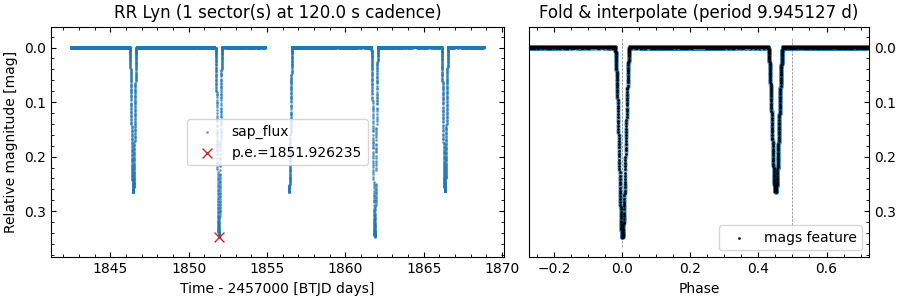

In [6]:
target_label = target_cfg.get("label", target)
exptime = lc.meta["FRAMETIM"] * lc.meta["NUM_FRM"] * u.s  

fig = plt.figure(figsize=(9, 3), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=1, width_ratios=(4, 3))
ax_lc = fig.add_subplot(gs[0, 0])
plotting.plot_lightcurve_on_axes(ax_lc, lc, "delta_mag", lc.meta["FLUX_ORIGIN"],
                                 primary_epoch=pe, primary_epoch_label=f"p.e.={pe.value:.6f}",
                                 ylabel="Relative magnitude [mag]", legend_loc="best", inverty=True,
                                 title=f"{target_label} ({sector_count} sector(s) at {exptime} cadence)")

ax_fld = fig.add_subplot(gs[0, 1], sharey=ax_lc)
plotting.plot_folded_lightcurve_on_axes(ax_fld, fold_lc, "delta_mag", None, show_phase_vlines=True,
                                        overlay_data=(phases, mags), overlay_data_label="mags feature",
                                        ylabel="", yticklabel_right=True, inverty=False,
                                        xlim=(min(phases), max(phases)), legend_loc="best",
                                        title=f"Fold & interpolate (period {period:.6f})")

plt.show()

### Estimate the JKTEBOP fitting parameters
This is where the magic happens!

Estimator is used to directly predict the values of the $r_A+r_B$, $k$, $J$,
$e\cos{\omega}$, $e\sin{\omega}$ and $b_P$ parameters, with the orbital inclination
($i$) derived from these, for use as input values of subsequent fitting with JKTEBOP.

If iterations >1 then the MC Dropout algorithm will be used which repeats the
requested predictions the given number of times with Dropout enabled. Dropout
randomly drops a proportion of the neurons in the full neural network, so in
this configuration each iteration will give a prediction from a different subset
of the full network.

In [7]:
# With iterations > 1 we use the MC Dropout algorithm, where the predictions
# are the mean & stddev of the predictions over the chosen number of iterations.
iterations = 1000
predictions = estimator.predict(np.array([mags]), None, iterations)

# Handle the estimator predicting bP rather than inc directly; we need inc for JKTEBOP
predicted_params = list(predictions.dtype.names)
if "inc" not in predicted_params and "bP" in predicted_params:
    print(f"{estimator.name} doesn't predict inc so we calculate it from other predictions")
    predictions = model_testing.append_calculated_inc_predictions(predictions)
    predicted_params += ["inc"]

print(f"\nPredicted JKTEBOP input parameters for {target} with 1-sigma uncertainties")
print(*(f"{p:>12s}: {predictions[p][0]:11.6f}" for p in predicted_params), sep="\n")

CNN-New-Ext0-bP-4096-None-250k doesn't predict inc so we calculate it from other predictions

Predicted JKTEBOP input parameters for RR Lyn with 1-sigma uncertainties
  rA_plus_rB:    0.150711+/-   0.027880
           k:    0.620143+/-   0.028660
           J:    0.788169+/-   0.029464
       ecosw:   -0.070254+/-   0.019573
       esinw:   -0.006125+/-   0.006320
          bP:    0.526605+/-   0.024868
         inc:   87.195414+/-   0.538527


### Perform JKTEBOP fitting on the target's lightcurves

The parameters estimated above and the ingested lightcurves are now used to generate
an equivalent pair of in & dat files for the target. JKTEBOP is invoked against these
to fit the lightcurve with the EBOP algorithm.

In [8]:
input_params = predictions.copy()
file_stem = f"quick-fit-{target_stripped}"
read_params = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "bP", "ecc", "omega", "phiS", "rA", "rB"]

# Generate the input files then perform the task 3 fit taking the preds or control as input params
# and supplementing them with parameter values and fitting instructions from the target's config.
fitted_vals = model_testing.fit_target(lc, target, input_params, target_cfg, read_params, file_stem)


Fitting RR Lyn (with 1 sector(s) of data) with JKTEBOP task 3...
  
JKTEBOP  v43  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-rr-lyn.par                              
>> Opened new LC output  file:  quick-fit-rr-lyn.out                              
>> Opened new model fit  file:  quick-fit-rr-lyn.fit                              
>> Read  17552 datapoints (with errors) from file quick-fit-rr-lyn.dat                              
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 44 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:  10.566 
>> Done iteration 2 to adjust errorbars. Chisqred values:  

### Review the JKTEBOP fitting results
For each fitted target, JKTEBOP produces parameter (par), model (fit) and
task output (out) files. For task 3 the out file contains a phase folded
copy of the fitted lightcurve and the residuals, which we plot below. When
running tasks 8 or 9, the out file contains simulation data so this plot is
not produced.

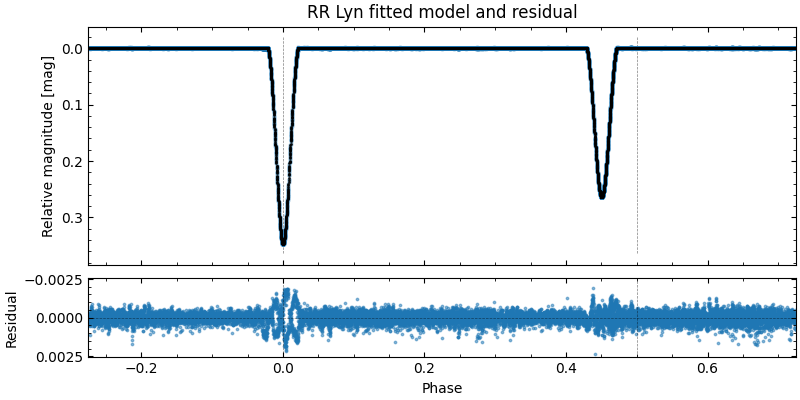

In [9]:
# Read the fit data from the out file, and roll the phases to match that used in estimations
with open(jktebop.get_jktebop_dir() /f"{file_stem}.out", mode="r", encoding="utf8") as ff:
    fit_data =  np.loadtxt(ff, usecols=[3, 4, 5], comments="#", dtype=np.double, unpack=True)
    fit_data[0][fit_data[0] > np.max(fold_lc.time).value] -= 1.

# A grid of two stacked Axes. Upper for the folded lc & model and lower for the residuals
fig = plt.figure(figsize=(8, 4), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=(3, 1))
ax_fld = fig.add_subplot(gs[0, 0])

plotting.plot_folded_lightcurve_on_axes(ax_fld, fold_lc, "delta_mag", show_phase_vlines=True,
                                        overlay_data=fit_data, overlay_data_label=None,
                                        xlabel="", ylabel="Relative magnitude [mag]", inverty=True,
                                        title=f"{target_label} fitted model and residual")
plt.setp(ax_fld.get_xticklabels(), visible=False) # Hides xtick labels on this part shared axes

ax_res = fig.add_subplot(gs[1, 0], sharex=ax_fld)
ax_res.scatter(x=fit_data[0], y=fit_data[2], s=3, alpha=.5)
abs_max_ylim = max(np.abs(ax_res.get_ylim()))
plotting.format_axes(ax_res, title="", xlabel="Phase", ylabel="Residual",
                    xlim=(min(phases), max(phases)), ylim=(abs_max_ylim, -abs_max_ylim))
(ymin, ymax) = ax_res.get_ylim()
ax_res.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
ax_res.hlines([0.0], min(phases), max(phases), linestyles="--", color="k", lw=.5, alpha=.5)
plt.show()

In [10]:
print(f"The JKTEBOP fitted paramters for {target} with formal errorbars (where given)")
print(*(f"{p:>12s}: {fitted_vals[p]:11.6f}" for p in fitted_vals.dtype.names), sep="\n")

The JKTEBOP fitted paramters for RR Lyn with formal errorbars (where given)
  rA_plus_rB:    0.141885+/-   0.000128
           k:    0.627860+/-   0.000990
           J:    0.814151+/-   0.003751
       ecosw:   -0.078072+/-   0.000003
       esinw:    0.000874+/-   0.000419
         inc:   87.487523+/-   0.020883
          L3:    0.038440+/-   0.003052
          pe: 1851.926273+/-   0.000011
      period:    9.945035+/-   0.000009
          bP:    0.499442+/-          0
         ecc:    0.078076+/-          0
       omega:  179.358784+/-          0
        phiS:    0.450349+/-          0
          rA:    0.087161+/-          0
          rB:    0.054725+/-          0


In [11]:
print(f"The predictions vs resulting fitted parameters for {target}")
fitted_labels = [n for n in predictions.dtype.names]
model_testing.predictions_vs_labels_to_table(predictions, fitted_vals, "Parameters",
                                             fitted_labels, label_head="Fitted")

The predictions vs resulting fitted parameters for RR Lyn
---------------------------------------------------------------------------------------------------------------
Parameters | rA_plus_rB          k          J      ecosw      esinw         bP        inc        MAE        MSE
---------------------------------------------------------------------------------------------------------------
Fitted     |   0.141885   0.627860   0.814151  -0.078072   0.000874   0.499442  87.487523
Prediction |   0.150711   0.620143   0.788169  -0.070254  -0.006125   0.526605  87.195414
Error      |  -0.008825   0.007717   0.025983  -0.007818   0.006998  -0.027163   0.292109   0.053802   0.012427
---------------------------------------------------------------------------------------------------------------

